In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier

# Kepler Exoplanet Search
NASA's Kepler Mission is a quest to search for planets that may be suitable for life. In order to do this, NASA surveyed many solar systems in the Milky Way and identified planets with unique qualities similar to Earth. These qualities inclue:
- Determine the percentage of terrestrial and large planets that are in or near the habitable zoen from a variety of stars
- Determine the distribution of sizes and shapes of orbits
- Determine the planet relectivities, size, masses and densities of short-period giant planets
- Identify additional planets in each solar system
- Determine the properties of stars that have planetary systems

## Transit Method of Detecting Extrasolar Planets
A "transit" is the event where a planet passes in front of a star, as viewed from Earth. Occasionally we can observe Venus or Mercury transit the Sun. Kepler finds planets by looking for diny dips in the brightness of a star when a planet crosses in front of it. Once detected, the planet's orbital size can be calculated from the period of the orbit, and the mass of the sun can be calculated using Kepler's Third Law. The size of the planet is found by analyzing the dip in the amount of light we perceive here on earth. When we have the planet's orbital size and temperature of the sun, we can assume some characteristics of the planet, such as temperature, and from that we can assume whether or not a planet is habitable.

source: https://www.nasa.gov/mission_pages/kepler/overview/index.html
NASA dataset: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi

In [2]:
df = pd.read_csv('cumulative.csv', delimiter=',')
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## About the Dataset
KOI: Kepler Object of Interest \\
`kepoi_name` the name of the target \\
`koi_disposition` the disposition in the literature towards being an expolanet canidate \\
`koi_pdisposition` the disposition from data analysis towards being an exoplanet canidate \\
`koi_score` A value between 0 and 1 that indicates the confidence of the koi disposition \\
`koi_period` the period of the orbit \\ 
`koi_impact` the impact of the transit. The dip of observed light. \\
`koi_slogg` The base-10 logarithm of the acceleration due to gravity at the surface of the star. \\
`koi_srad` The radius of the sun \\

Locational data relative to Earth \\
`ra` Right ascension. https://en.wikipedia.org/wiki/Right_ascension \\
`dec` Declination. https://en.wikipedia.org/wiki/Declination \\

more explanations: https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [3]:
# make a new column that is a binary classificaiton of whether or not a planet is a canidate
disposition = [0] * len(df['koi_pdisposition'])
for i in range(len(df['koi_pdisposition'])):
    disposition[i] = 1 if (df['koi_pdisposition'][i] == 'CANDIDATE') else 0 

df.insert(1, "disposition", disposition)

columns = ["disposition", "koi_period", "koi_impact", "koi_srad", "koi_slogg", "ra", "dec"]
df = df[columns].dropna()
print(df)


      disposition  koi_period  koi_impact  koi_srad  koi_slogg         ra  \
0               1    9.488036       0.146     0.927      4.467  291.93423   
1               1   54.418383       0.586     0.927      4.467  291.93423   
2               0   19.899140       0.969     0.868      4.544  297.00482   
3               0    1.736952       1.276     0.791      4.564  285.53461   
4               1    2.525592       0.701     1.046      4.438  288.75488   
...           ...         ...         ...       ...        ...        ...   
9559            0    8.589871       0.765     1.088      4.296  298.74921   
9560            0    0.527699       1.252     0.903      4.529  297.18875   
9561            1    1.739849       0.043     1.031      4.444  286.50937   
9562            0    0.681402       0.147     1.041      4.447  294.16489   
9563            0    4.856035       0.134     1.193      4.385  297.00977   

            dec  
0     48.141651  
1     48.141651  
2     48.134129  
3  

Text(0, 0.5, 'dec')

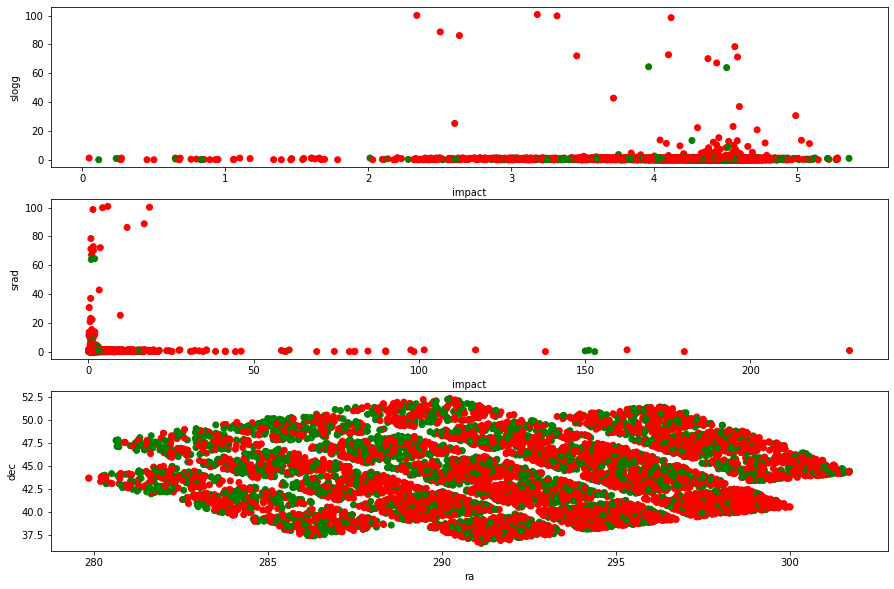

In [4]:
# visualize data

# custom color map for our dataset
color = np.where(df['disposition'] == 1, 'green', 'red')
fig, axs = plt.subplots(3, figsize=(15,10))

# make sure to play around with these to better understand the dataset

axs[0].scatter(df['koi_slogg'], df['koi_impact'], c=color)
axs[0].set_xlabel("impact")
axs[0].set_ylabel("slogg")

axs[1].scatter(df['koi_srad'], df['koi_impact'], c=color)
axs[1].set_xlabel("impact")
axs[1].set_ylabel("srad")

axs[2].scatter(df['ra'], df['dec'], c=color)
axs[2].set_xlabel("ra")
axs[2].set_ylabel("dec")

In [5]:
#X_train, X_test, Y_train, Y_test = train_test_split(df)
X = pd.DataFrame(columns=['koi_slogg', 'koi_srad', 'koi_impact', 'ra', 'dec'], data=df)
Y = pd.DataFrame(columns=['disposition'], data=df).values.ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# BEGIN SOLUTION
# make a model
model = KNeighborsClassifier(n_neighbors=1)

model.fit(X_train, Y_train)

# make predictions
predictions = model.predict(X_test)

# test accuracy
print(matthews_corrcoef(Y_test, predictions))

# END SOLUTION

0.24374244941105405


In [6]:
# having a bit of fun looking for optimal neighbors

n_best = 1
best_score = 0
for i in range(1, 100):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    corr = matthews_corrcoef(Y_test, predictions)
    print(i, ":", corr)
    if corr > best_score:
        best_score = corr
        n_best = i

print(n_best, 'is the best n!')

1 : 0.24374244941105405
2 : 0.2469619340049164
3 : 0.2720370339777391
4 : 0.27529953848425776
5 : 0.2369353281360676
6 : 0.24117939466147054
7 : 0.25909114815084927
8 : 0.294984824782945
9 : 0.26538982738362416
10 : 0.28798648032419605
11 : 0.2809147345966406
12 : 0.265080958361756
13 : 0.24949036450653167
14 : 0.26695885686863596
15 : 0.25342153435492365
16 : 0.24515965793723343
17 : 0.2400156779551618
18 : 0.25599716595790334
19 : 0.27122067277670964
20 : 0.28003852193726636
21 : 0.27976710399206545
22 : 0.28015563629644263
23 : 0.26883263245699457
24 : 0.2692506764200676
25 : 0.2502751525797644
26 : 0.26295986576244323
27 : 0.2502751525797644
28 : 0.2587511787125283
29 : 0.24818526488607934
30 : 0.2610429657257846
31 : 0.24609610868944728
32 : 0.24837588944942257
33 : 0.24682533103987128
34 : 0.264092214341652
35 : 0.24970654279422835
36 : 0.26162498866017075
37 : 0.257615658340143
38 : 0.2552811260548277
39 : 0.2570602598450154
40 : 0.2618583913748056
41 : 0.25742553715461364
42 : 